# Programme d'Assignation des Vétérinaires de l'État (AVÉ)

© Matthieu Marionneau, matmarionneau@gmail.com<br>
© https://www.topcoder.com/community/data-science/data-science-tutorials/assignment-problem-and-hungarian-algorithm/ pour l'algorithme hongrois


__Fonctionnement du programme__ :<br>
Dans une nouvelle cellule en bas du programme (pas besoin de refaire une nouvelle cellule à chaque fois), copier les commandes

_ave=AVE(inputFile=< fichierdonnées>, deptMax=< 1-6>, nCombMax=< 20>, useRequiredConstrains=< True False> verbose=< 0-1>)<br>
ave.main()_<br>

et replacer les valeurs < xxx> par ce qui est nécessaire. (Voir exemple avec les données de 2017 en bas de la page). Le programme affichera les résultats, et sauvegardera les résultats dans les fichiers "assignationX".txt et "assignationX".png (X étant un identifiant unique pour chaque combinaison obtenue)<br>


__Variables d'entrées du programme__ :
- inputFile : fichier CSV (en principe pouvant être exporté d'excel/googlesheet) contenant les différents choix. Ce fichier DOIT être d'une forme similaire à :<br>
    ISPVs, Poste 1, Poste 2, Optionnel 1, Poste 3<br>
    Charles, 3, 1, 2, 2<br>
    Isabelle, 1, 2, 3, 4<br>
    Jeanne, 10000000, 10000000, 1, 10000000<br>
    
    Contraintes du fichier CSV :
        - les postes avec contraintes doivent s'appeler "Poste X" (respect du P majuscule)
        - les postes ne pouvant être attribués à certains ISPVs (FCPR, agros) doivent recevoir une assignation de 10 million (10000000)
        - en cas de postes de même contentement x, le poste de choix suivant doit être assigné au choix x+1: e.g. pour 3 postes (1,2,3) et avec les postes 1 et 2 considérés tous les deux comme 1er choix, le poste 3 est considéré comme le 2e choix et non pas comme le 3e choix.
     Autres informations :
         - l'ordre des postes et des ISPVs dans le fichier de données n'importe pas
    
- deptMax [1-6] : niveau de complexité des solutions alternatives : <br>
    niveau 1 : calcul d'une unique solution <br>
    niveau 2-6 : recherche de la meilleure solution et de solutions alternatives de plus en plus complexes. <br>
- nCombMax : nombre de combinaisons maximales retenues. Ce nombre s'ajuste automatiquement afin de garantir l'observation de tous les résultats possibles à coûts égaux ou inférieurs
- useRequiredConstrains [True-False] : utilise les contraintes de postes obligatoires (activé par défaut)
- verbose [0-1] : active l'impression des détails/vérifications



## librairies et variables globales

In [1]:
import os
import numpy as np
import copy

import scipy.stats as spstat
from io import BytesIO
import matplotlib.pyplot as plt
from IPython.display import display, Image, HTML
import base64
import csv

#constants
FORBID=10000000

## algorithme principal (algorithme hongrois)

In [2]:
class HungarianAlgorithm():
    """ This class contains the main algorithm used to assign the ISPVs to the different
    positions. This follows the code proposed in 
    https://www.topcoder.com/community/data-science/data-science-tutorials/assignment-problem-and-hungarian-algorithm/
    """
    def __init__(self,costMatrix,constrains=None,verbose=0):

        self.verbose=verbose
        
        #external parameters
        self.costMatrix=np.array(costMatrix, dtype=np.int32)
        self.constrains=constrains
        
        # transform the matrix to transform the problem
        # in a maximum-weighted matching problem
        # ==>find "reduced" maximum cost for bots
        self.maxCost=np.amax(self.costMatrix)%FORBID
      
        #internal parameters
        shape=self.costMatrix.shape
        idx=np.argmax(shape)
        self.N=shape[idx]
        self.nBots=shape[idx]-shape[1-idx]
        if verbose:
            print "checking the cost matrix size : size=",self.N," ndof=",self.nBots
        #squaring the cost matrix with bots
        self.makeSquareMatrix()

         # transform the matrix to transform the problem
        # in a maximum-weighted matching problem
        # ==>perform the transformation
        self.maxCost=np.amax(self.costMatrix)
        self.costs=self.maxCost-self.costMatrix

        #algorithm placeholders
        self.lx=np.zeros((self.N), dtype=np.int32)
        self.ly=np.zeros((self.N), dtype=np.int32)
        self.xy=np.full((self.N),-1, dtype=np.int32)
        self.yx=np.full((self.N),-1, dtype=np.int32)
        self.S=np.zeros((self.N), dtype=bool)
        self.T=np.zeros((self.N), dtype=bool)
        self.slack=np.zeros((self.N), dtype=np.int32)
        self.slackx=np.zeros((self.N), dtype=np.int32)
        self.prev=np.zeros((self.N), dtype=np.int32)

        self.maxMatch=0

    def makeSquareMatrix(self):
        if self.nBots!=0:
            #creating nbots with N choices with large cost
            #(lower than forbidden combinations)
            bots=np.full((self.nBots,self.N),max(self.N+20,self.maxCost+20),dtype=np.int32)
            if self.constrains!=None:
                for c in self.constrains:
                    bots[:,c]=FORBID

            self.costMatrix=np.concatenate((self.costMatrix, bots))
            if self.verbose:
                print("inclusion of bots, updated cost matrix")
                print self.costMatrix
                print("===============")
        
    def initLabels(self):
        #initialize labels
        self.lx[:]=0
        self.ly[:]=0
        for ix in range(0,self.N):
            for iy in range(0,self.N):
                self.lx[ix]=max(self.lx[ix], self.costs[ix][iy])
        

    def reinitialize(self):
        self.maxMatch=0
        self.lx[:]=0
        self.ly[:]=0
        self.xy[:]=-1
        self.yx[:]=-1
        self.S[:]=False
        self.T[:]=False
        self.slack[:]=0
        self.slackx[:]=0
        self.prev[:]=0
        
    def updateLabels(self):
        delta=1000000000
        for i in range(0,self.N):
            if not self.T[i]: delta=min(delta,self.slack[i])
        for i in range(0,self.N):
            if self.S[i]: self.lx[i] -=delta
        for i in range(0,self.N):
            if self.T[i]: self.ly[i] += delta    
        for i in  range(0,self.N):
            if not self.T[i]: self.slack[i] -= delta
            
    def addToTree(self,ix,prevx):
        self.S[ix]=True
        self.prev[ix]=prevx
        for iy in range(0,self.N):
            if self.lx[ix]+self.ly[iy]-self.costs[ix][iy] < self.slack[iy]:
                self.slack[iy]=self.lx[ix]+self.ly[iy]-self.costs[ix][iy]
                self.slackx[iy]=ix

    def augment(self,):
        #main function of the algorithm

        #perfect matching check
        if self.maxMatch==self.N:
            if self.verbose: print("perfect matching found")
            return

        root=0
        q=np.zeros((self.N))
        wr=0
        rd=0

        #position in queue, init set of S,T,prev
        self.S[:]=False
        self.T[:]=False
        self.prev[:]=-1
        for ix in range(0,self.N):
            if self.xy[ix]==-1:
                root=ix
                q[wr]=ix
                wr+=1
                self.prev[ix]=-2
                self.S[ix]=True
                break

        for iy in range(0,self.N):
            self.slack[iy] = self.lx[root]+self.ly[iy]-self.costs[root][iy]
            self.slackx[iy] = root
        #second part of augment() function
        ix=int(0)
        iy=int(0)
        corrector=1
        while True:
            while rd<wr:
                ix=int(q[rd])
                rd+=1
                for iy in range(0,self.N):
                    if self.costs[ix][iy] == (self.lx[ix] + self.ly[iy]) and not self.T[iy]:
                        if self.yx[iy]==-1: 
                            corrector=0
                            break
                        self.T[iy]=True
                        q[wr]=self.yx[iy]
                        wr+=1
                        self.addToTree(self.yx[iy],ix)
                if iy==self.N-1: #bloody fix as the for loop does not behave in the same way as in C++
                    iy+=corrector
                if iy<self.N: break #augmenting path found!
            if iy<self.N: break #augmenting path found!
            # augmenting path not found, so improve labeling
            self.updateLabels()
            wr=0
            rd=0 
            corrector=1
            for iy in range(0,self.N):
                #in this cycle we add edges that were added to the equality graph as a
                #result of improving the labeling, we add edge (slackx[y], y) to the tree if
                #and only if !T[y] && slack[y] == 0, also with this edge we add another one
                #(y, yx[y]) or augment the matching, if y was exposed
                if (not self.T[iy]) and self.slack[iy]==0:
                    if self.yx[iy]==-1:
                        ix = self.slackx[iy]
                        corrector=0
                        break
                    else:
                        self.T[iy]=True
                        if not self.S[self.yx[iy]]:
                            q[wr]=self.yx[iy]
                            wr+=1
                            self.addToTree(self.yx[iy],self.slackx[iy])
            if iy==self.N-1: #bloody fix as the for loop does not behave int he same way as in C++
                    iy+=corrector
            if iy<self.N:#augmenting path found!
                break
        
        if iy<self.N: #we found augmenting path!
            self.maxMatch+=1 #increment matching
            #in this cycle we inverse edges along augmenting path
            cx=int(ix)
            cy=int(iy)
            ty=-1
            while cx!=-2:
                ty=self.xy[cx]
                self.yx[cy]=cx
                self.xy[cx]=cy
                cx=self.prev[cx]
                cy=ty
            self.augment()

## code maître

In [3]:
class AVE():
    """This class extract the best possible ISPVs-position matching based on the preferencies 
    of the ISPVs. 
    Input variables :
    inputFile : csv file containing the preferency matrix
    deptMax : leve of complexity for alternate solutions [1-6]. 1 means only the best measurement
    mCombMax : maximum number of combination retained by the program
    useRequiredConstrains : enable or disable the constrains on positions to be absolutely assigned 
    verbose : enable the print statements"""
    def __init__(self,inputFile, deptMax, nCombMax=20, useRequiredConstrains=True, verbose=1):
        
        #input values
        self.namesISPVs=[]
        self.positions=[]
        self.globalCosts=[]
        self.globalConstrains=[]
        self.useReqCons=useRequiredConstrains
        
        self.OFFSET=100000
        
        self.verbose=verbose
        self.deptMax=deptMax
        self.nCombMax=nCombMax
        self.file=self.getData(inputFile, verbose=1)
        
        self.nISPVs=len(self.globalCosts)
        
    def getData(self,fileName, verbose):
        """Read the input file, convert the contents and store them"""
        
        self.namesISPVs=[]
        self.positions=[]
        self.globalCosts=[]
        self.globalConstrains=[]
        with open(fileName) as csvfile:
            reader = csv.DictReader(csvfile)
            self.positions=reader.fieldnames[1:]
            for i,p in enumerate(self.positions):
                if "Poste" in p: 
                    self.globalConstrains.append(i)
            for i,row in enumerate(reader):
                self.namesISPVs.append(row['ISPVs'])
                self.globalCosts.append([])
                for j,col in enumerate(self.positions):
                    self.globalCosts[i].append(int(row[col]))

            displayCosts=np.array(self.globalCosts)
            displayCosts[displayCosts==FORBID]=-1
            if verbose:
                print "ISPVs:\n",np.array(self.namesISPVs),"\n"
                print "postes:\n",np.array(self.positions),"\n"
                print "index des contraintes:\n", self.globalConstrains,"\n"
                print "===== matrice de coût(choix) (postes interdits=-1 pour visualisation uniquement) ===="
                print displayCosts

        
    def getMatching(self,costs,constrains):
        """get a combination with the hungarian algorithm"""
        
        if self.verbose:
            print("==================== search for new combination ==============")
        
        hgAlgo=HungarianAlgorithm(costs,constrains,self.verbose)
        hgAlgo.initLabels()
        hgAlgo.augment()
                
        totCost=sum([hgAlgo.costs[x][hgAlgo.xy[x]] for x in range(0,hgAlgo.N) ])
        totCost2=sum([costs[x][hgAlgo.xy[x]] for x in range(0,self.nISPVs) ])
        if self.verbose:
            print "total cost for best score:",totCost2,"/",totCost

        result={}
        if self.verbose:
            print "=== result === "
        for i in range(0,self.nISPVs):
            if self.verbose:
                 print "ispv : ",namesISPVs[i],"\t-> cost/rank=",costs[i][hgAlgo.xy[i]],"\tposition=",hgAlgo.xy[i],"("+positions[hgAlgo.xy[i]]+")"
            cost=costs[i][hgAlgo.xy[i]]
            result[i]=(hgAlgo.xy[i],cost)# if cost<100000 else cost%100000)
        if self.verbose:
            for i in range(self.nISPVs,len(hgAlgo.xy)):
                print " bot : ",i,"\t position=",hgAlgo.xy[i],"("+self.positions[hgAlgo.xy[i]]+")"
    
        return result,totCost2,hgAlgo.xy
    
    def getAlternateMatchings(self,initCosts,constrains,initRanks):
        """Get alternate combinations of the hungarian algorithm by alterating the 
        ranks chosen in the first iteration"""

        results={}
        offset=self.OFFSET
    
        #first, look at alternate solution of "dept 2"
        # by forbidding one choice at a time for each ISPV
        for isp in range(0,self.nISPVs):
            aCosts = copy.deepcopy(initCosts)
            aCosts[isp][initRanks[isp]]=offset
            res, cost, ranks=self.getMatching(aCosts,constrains)           
            if cost in results.keys():
                results[cost].append( res )
            else:
                results[cost]=[res]
            
            #alternate possibility with two level dept forbidden choices, dept 3
            if self.deptMax<3: continue
            aCosts = copy.deepcopy(aCosts)
            aCosts[isp][ranks[isp]]=offset
            res, cost, ranks=getMatching(aCosts,constrains)
            if cost in results.keys():
                results[cost].append( res )
            else:
                results[cost]=[res]

            #second, look at alternate solution of "dept 4"
            # by forbidding two choice at a time for two ISPVs
            if self.deptMax<4: continue
            for isp2 in range(0,self.nISPVs):
                aCosts = copy.deepcopy(initCosts)
                aCosts[isp][initRanks[isp]]=offset
                aCosts[isp2][initRanks[isp2]]=offset
                res, cost, ranks=self.getMatching(aCosts,constrains)

                if cost in results.keys():
                    results[cost].append( res )
                else:
                    results[cost]=[res]

                #alternate possibility with two level dept forbidden choices
                # for two ISPVs, dept 5
                if self.deptMax<5: continue
                aCosts = copy.deepcopy(aCosts)
                aCosts[isp][ranks[isp]]=offset
                aCosts[isp2][ranks[isp2]]=offset
                res, cost, ranks=self.getMatching(aCosts,constrains)
                if cost in results.keys():
                    results[cost].append( res )
                else:
                    results[cost]=[res]

                #dept 6, three choices at a time, and we stop here
                # for varying simultaneously several choices
                if self.deptMax<6: continue
                for isp3 in range(0,self.nISPVs):
                    aCosts = copy.deepcopy(initCosts)
                    aCosts[isp][initRanks[isp]]=offset
                    aCosts[isp2][initRanks[isp2]]=offset
                    aCosts[isp3][initRanks[isp3]]=offset
                    res, cost, ranks=self.getMatching(aCosts,constrains)
                    if cost in results.keys():
                        results[cost].append( res )
                    else:
                        results[cost]=[res]

        return results
    
    def checkConstrains(self,result,verbose):
        """Check constrains (mandatory positions and IPSV constrains) for a given result"""

        if self.useReqCons :
            poss=[result[k][0] for k in result.keys()]
            for c in self.globalConstrains:
                if c not in poss:
                    if verbose:
                        print"result not supported, constrains unfulfilled : ",c,"("+self.positions[c]+")"
                    return False
        
        for k in result.keys():
            if self.globalCosts[k][result[k][0]]==FORBID:
                if verbose:
                    print"result not supported, wrong assignment to ",self.namesISPVs[k],":",c,"("+self.positions[c]+")"
                return False


        return True

    def checkCombExistence(self,refs, opt):
        """check if the obtained combination already exists or not"""
        
        exists=False
        for ref in refs:
            nDiff=len(ref.keys())
            for k in ref.keys():
                if opt[k][0]==ref[k][0]:
                    nDiff-=1
            if nDiff==0:
                exists=True
                break
        if exists: return False
        else: return True


    def plotdesc(self,fig, text, name, iwidth=None):
        """plot the associated statistics"""
        
        bio = BytesIO()
        # save fig as png to bytes IO instead to disk
        fig.savefig(bio, format='png')
        fig.savefig(name+'.png', bbox_inches='tight')
        plt.close(fig)
        iwidth = ' width={0} '.format(iwidth) if iwidth is not None else ''
        img_tag = "<img src='data:image/png;base64," + base64.b64encode(bio.getvalue()) + "'{0}/>".format(iwidth)
        datatable = '<table><tr><td>{0}</td><td>{1}</td></tr></table>'.format(img_tag, text)
        display(HTML(datatable))


    def plotFigure(self,ranks, cost, stats, name):
        """plot the histogram and the associated statistics"""
        
        fig, ax = plt.subplots(1,1, figsize=(6,4))   
        ax.hist(ranks, bins=np.arange(stats['minRank']-0.5,stats['maxRank']+1+0.5,1),histtype='bar',alpha=0.5, ec='black')
        ax.set_xlabel('choix')
        ax.set_ylabel('#ISPVS')
        #ax.set_xticklabels(tick_labels.astype(int))
        #ax.set_yticklabels(tick_labels.astype(int))
        text = '<h4> résultats:</h4><BR>somme des choix='+str(cost)
        text+= '<BR>moyenne='+str(stats['mean'])
        text+= '<BR>déviation standard='+str(stats['sigma'])
        text+= '<BR>médiane='+str(stats['median'])
        text+= '<BR>min='+str(stats['minRank'])
        text+= '<BR>max='+str(stats['maxRank'])
        self.plotdesc(fig, text, name, iwidth='500px')    

    def saveAndDisplay(self,result, cost, name):
        """Save the combination in ASCII file, save the histogram, and display the result"""
        
        #first save the ranks and positions
        ranks=[result[k][1] for k in result.keys()]
        mean=np.mean(ranks)
        sigma=np.std(ranks)
        median=np.median(ranks)
        minRank=np.amin(ranks)
        maxRank=np.amax(ranks)
        stats={"mean":mean,
               "sigma":sigma,
               "median":median,
               "minRank":minRank,
               "maxRank":maxRank}
        with open(name+'.txt', 'w') as f:
            f.write(name+'\n')
            f.write('somme des choix='+str(cost)+'\n')
            f.write('moyenne='+str(mean)+'\n')
            f.write('déviation standard='+str(sigma)+'\n')
            f.write('médiane='+str(median)+'\n')
            f.write('min='+str(minRank)+'\n')
            f.write('max='+str(maxRank)+'\n')
            f.write('\nispv\tposte\tchoix\n')
            for k in result.keys():
                line=self.namesISPVs[k]+"\t"+self.positions[result[k][0]]+"\t"+str(result[k][1])+'\n'
                f.write(line)

        #now display
        self.plotFigure(ranks,cost, stats, name)
        
        
    def main(self, deptMax=1, nCombMax=20, verbose=0):
        """main function, executing the full AVE program"""
        
        constrains=self.globalConstrains if self.useReqCons else None
        deptMax=self.deptMax
                
        res,cost,ranks=self.getMatching(self.globalCosts,constrains)

        finalResults={}
        finalResults[cost]=[ res ]
        if deptMax>=2:
            alternateResults=self.getAlternateMatchings(self.globalCosts,
                                                        constrains,
                                                        ranks)
            for key in alternateResults.keys():
                if key not in finalResults.keys():
                    finalResults[key]=[]
                for opt in alternateResults[key]:
                    if len(finalResults[key])!=0:
                        valid=self.checkCombExistence(finalResults[key],opt)
                    else: 
                        valid=True
                    if valid:
                        finalResults[key].append(opt)

             
        print("\n====================== resultats ===============")
        nCombs=0 
        for key in finalResults.keys():    
            print "somme des choix: ",key,"-->>",len(finalResults[key])," combinaisons"
            nCombs+=len(finalResults[key])
        print nCombs,"combinaisons possibles avant vérification des contraintes"

        #combination found, trim them if needed
        nCombs=0
        keyMax=-1
        validResults={}
        for key in finalResults.keys():
            tmp=[k for k in finalResults[key] if self.checkConstrains(k,1) ]
            nCombs+=len(tmp)
            validResults[key]=tmp
            if nCombs>nCombMax:
                keyMax=key
                break

        print nCombs,"combinaisons possibles après vérification des contraintes"
        for key in validResults.keys():    
            print "somme des choix: ",key,"-->>",len(validResults[key])," combinaisons"
        print "\n"

        #at that level, we know what to keep and we 
        #store the results and compute statistical quantities
        ii=1
        for k in validResults.keys():
            for i,r in enumerate(validResults[k]):
                name="assignation"+str(ii)
                print "\n========================== assignation",ii,"====================================="
                self.saveAndDisplay(r,k,name)
                #and we want the results to be printed as well
                print 'somme des choix='+str(k)+'\nispv\tposte\tchoix'
                for isp in r.keys():
                    print self.namesISPVs[isp]+"\t"+self.positions[r[isp][0]]+"\t\t"+str(r[isp][1])#+'\n'
                    #print str(isp)+"\t"+str(r[isp][0])+"\t"+str(r[isp][1])
                ii+=1


## validation sur données de 2017

ISPVs:
['Agnes' 'Cecile' 'Claudine' 'Elise' 'FCPR' 'Helene' 'Linda' 'Nathalie'
 'Sofia' 'X' 'XX' 'XXX'] 

postes:
['Poste 1' 'Poste 2' 'Optionnel 1' 'Optionnel 2' 'Poste 3' 'Poste 4'
 'Poste 5' 'Optionnel 3' 'Poste 6' 'Poste 7' 'Poste 8' 'Optionnel 4'
 'Poste 9' 'Poste 10' 'Optionnel 5' 'Optionnel 6' 'Optionnel 7'] 

index des contraintes:
[0, 1, 4, 5, 6, 8, 9, 10, 12, 13] 

===== matrice de coût(choix) (postes interdits=-1 pour visualisation uniquement) ====
[[11 15 12  6  3 10  8  1  2 14  7 13 16  9  5 17  4]
 [ 6 12  4  5 17 10 11  3 13  9 15  2  8 16  7 14  1]
 [ 5 17 11  7  3  1  4 10  6 13 15 14  2 12  9 16  8]
 [11 10  4 16  3 17  8  1  9 12 14  6 13 15  7  2  5]
 [-1 -1  7  1 -1 -1 -1  5 -1 -1 -1  2 -1 -1  4  6  3]
 [17  2 13  6  9  1 14 15 10  4 11  5  7  3 12 16  8]
 [ 3  1 -1  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1]
 [16  3 13 11  6  2  4 10 15  7  8  5  9  1 14 12 17]
 [10 11 16  5  2  8  4 15  7  6  9  1 17  3 13 14 12]
 [ 6  3 10 13  7  9 15  2  4  8 17  5 14  1 12 16 

,résultats:somme des choix=18moyenne=1.5déviation standard=0.645497224368médiane=1.0min=1max=3

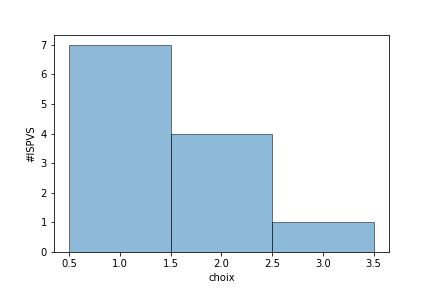

somme des choix=18
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 7		1
Claudine	Poste 9		2
Elise	Optionnel 6		2
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 10		1
Sofia	Optionnel 4		1
X	Optionnel 3		2
XX	Poste 3		3
XXX	Poste 1		1

========================== assignation 2 =====================================


,résultats:somme des choix=18moyenne=1.5déviation standard=0.5médiane=1.5min=1max=2

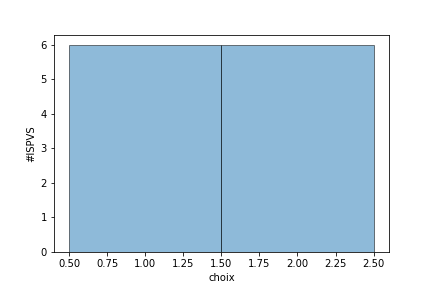

somme des choix=18
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 4		2
Claudine	Poste 9		2
Elise	Optionnel 6		2
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 10		1
Sofia	Poste 3		2
X	Optionnel 3		2
XX	Optionnel 7		1
XXX	Poste 1		1

========================== assignation 3 =====================================


,résultats:somme des choix=19moyenne=1.58333333333déviation standard=0.953793595188médiane=1.0min=1max=4

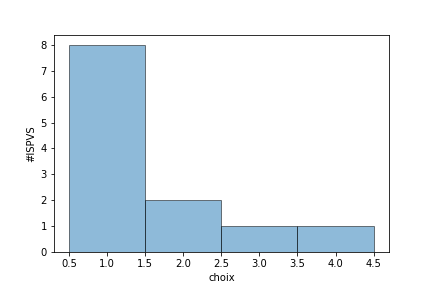

somme des choix=19
ispv	poste	choix
Agnes	Optionnel 3		1
Cecile	Optionnel 7		1
Claudine	Poste 9		2
Elise	Optionnel 6		2
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 10		1
Sofia	Optionnel 4		1
X	Poste 6		4
XX	Poste 3		3
XXX	Poste 1		1

========================== assignation 4 =====================================


,résultats:somme des choix=19moyenne=1.58333333333déviation standard=0.640095478989médiane=1.5min=1max=3

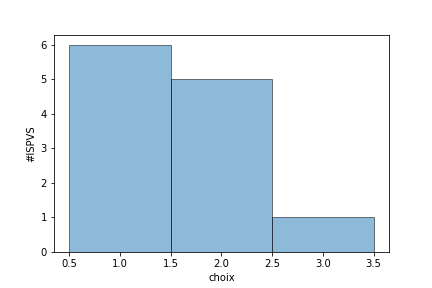

somme des choix=19
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 7		1
Claudine	Poste 9		2
Elise	Poste 3		3
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Optionnel 6		2
Nathalie	Poste 10		1
Sofia	Optionnel 4		1
X	Optionnel 3		2
XX	Poste 2		2
XXX	Poste 1		1

========================== assignation 5 =====================================


,résultats:somme des choix=19moyenne=1.58333333333déviation standard=0.640095478989médiane=1.5min=1max=3

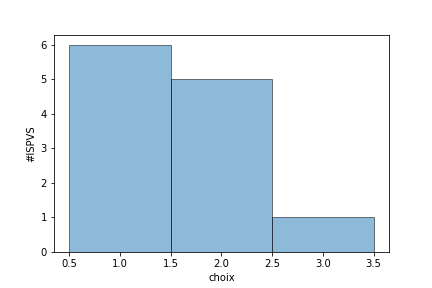

somme des choix=19
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 7		1
Claudine	Poste 9		2
Elise	Optionnel 3		1
FCPR	Optionnel 2		1
Helene	Poste 2		2
Linda	Optionnel 6		2
Nathalie	Poste 4		2
Sofia	Optionnel 4		1
X	Poste 10		1
XX	Poste 3		3
XXX	Poste 1		1

========================== assignation 6 =====================================


,résultats:somme des choix=19moyenne=1.58333333333déviation standard=0.953793595188médiane=1.0min=1max=4

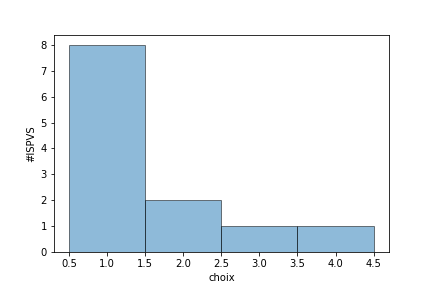

somme des choix=19
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 7		1
Claudine	Poste 9		2
Elise	Optionnel 3		1
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 5		4
Sofia	Optionnel 4		1
X	Poste 10		1
XX	Poste 3		3
XXX	Poste 1		1

========================== assignation 7 =====================================


,résultats:somme des choix=20moyenne=1.66666666667déviation standard=0.942809041582médiane=1.0min=1max=4

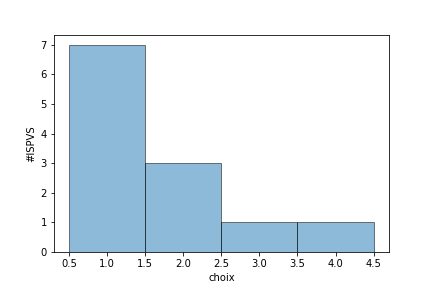

somme des choix=20
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 7		1
Claudine	Poste 5		4
Elise	Optionnel 6		2
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 10		1
Sofia	Optionnel 4		1
X	Optionnel 3		2
XX	Poste 3		3
XXX	Poste 1		1

========================== assignation 8 =====================================


,résultats:somme des choix=20moyenne=1.66666666667déviation standard=0.7453559925médiane=1.5min=1max=3

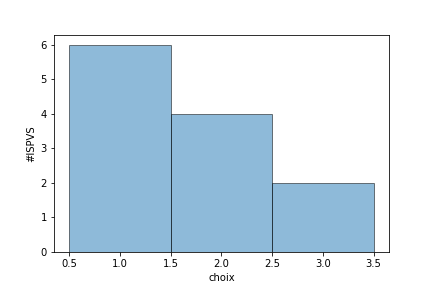

somme des choix=20
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 7		1
Claudine	Poste 9		2
Elise	Optionnel 6		2
FCPR	Optionnel 2		1
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 10		1
Sofia	Optionnel 4		1
X	Optionnel 3		2
XX	Poste 3		3
XXX	Optionnel 1		3

========================== assignation 9 =====================================


,résultats:somme des choix=21moyenne=1.75déviation standard=0.829156197589médiane=2.0min=1max=4

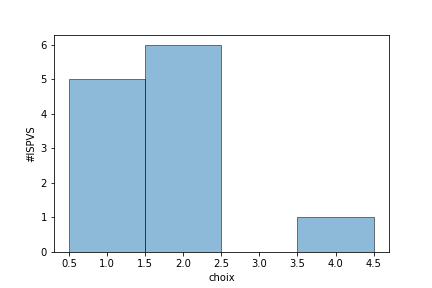

somme des choix=21
ispv	poste	choix
Agnes	Poste 6		2
Cecile	Optionnel 1		4
Claudine	Poste 9		2
Elise	Optionnel 6		2
FCPR	Optionnel 4		2
Helene	Poste 4		1
Linda	Poste 2		1
Nathalie	Poste 10		1
Sofia	Poste 3		2
X	Optionnel 3		2
XX	Optionnel 7		1
XXX	Poste 1		1


In [6]:
# N.B. le resultat donné par le tableur excel de 2017 ne gère pas les contraintes de postes obligatoires
# par conséquent, la variable useRequiredConstrains est désactivée dans cette instance du programme
# On note que le poste 8 obligatoire n'est pas pourvu. 
# Si l'option est réactivée, les résultats seront sensiblement différent de façon à pourvoir l'ensemble
# des postes obligatoires

ave=AVE(inputFile='postes2017', 
        deptMax=2, 
        nCombMax=20, 
        useRequiredConstrains=False, 
        verbose=0)
ave.main()